In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [12]:
# Configuração do dataset
symbol = 'DIS'  # Empresa escolhida
start_date = '2018-01-01'
end_date = '2024-07-20'

# Baixar os dados
df = yf.download(symbol, start=start_date, end=end_date)

# Pre-processamento
df = df[['Close']]  # Utilizamos apenas o preço de fechamento
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close_scaled'] = scaler.fit_transform(df[['Close']])

# Função para criar sequências temporais
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)


[*********************100%***********************]  1 of 1 completed


In [13]:
# Configuração dos dados
time_steps = 60
data = df['Close_scaled'].values
X, y = create_sequences(data, time_steps)

# Divisão treino/validação/teste
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.2)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

Criação do modelo usando os dados

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [15]:
# Construção do modelo LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Previsão de um único valor (preço de fechamento)
])

c:\Users\Pedro Miceli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Compilação do modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento do modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Avaliação do modelo
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0783 - val_loss: 0.0062
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0064 - val_loss: 0.0012
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0035 - val_loss: 0.0012
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0034 - val_loss: 0.0010
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0030 - val_loss: 9.0422e-04
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0031 - val_loss: 9.1852e-04
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0029 - val_loss: 9.2927e-04
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

c:\Users\Pedro Miceli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


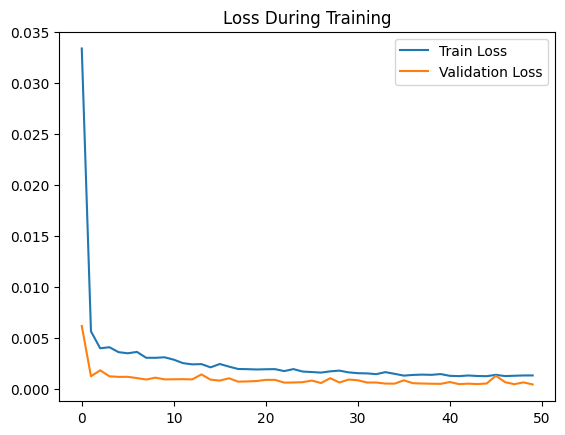

In [17]:
# Plotando o histórico de treinamento
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss During Training")
plt.show()

In [18]:
# Salvar o modelo em formato HDF5 (.h5)
model.save('lstm_stock_model.h5')
print("Modelo salvo como 'lstm_stock_model.h5'.")

# Ou salvar como um diretório completo
model.save('lstm_stock_model_dir')
print("Modelo salvo no diretório 'lstm_stock_model_dir'.")

Modelo salvo como 'lstm_stock_model.h5'.


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=lstm_stock_model_dir.